**Conversion from notebook to Python Script.**

Going modular involves turning notebook code into a series of diff Python scripts that offer similar functionality. Most useful cells are taken from the notebook.

Going modular is wanted because for large scale projects, Python scripts are more reproducible and easier to run.

Libraries like nb-dev by fast.ai enable one to write whole Python libs (including docs) with Jupyter Notebooks.

**One of the pros of using Python scripts is for larger projects, they can be run on cloud vendors (or servers).**

However, there are many possible workflows for writing machine learning code.

**Argument flags** are the values passed for hyperparameters or variables set in the terminal/command line to run some Python script.

For ex, python train.py --model tinyvgg --batch_size 32 --lr 0.001 --num_epochs 10

Here, all the argument flags are those which start with '--'.  train.py is the main training script of the model.

Because writing reproducible and understandable code is important, each of the fns/classes put into scripts has been created with **Google's Python docstring style** in mind.

Along with this, all the impots of each script are at the top.

### 0. Creating folder for storing Pyton scripts

In [1]:
import os
os.makedirs("going_modular", exist_ok = True)

### 1. Get data

In [2]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If image_path doesn't exist, download and prepare it.
if image_path.is_dir():
    print(f"{image_path} dir exists.")
else:
    print(f"Couldn't find {image_path} dir, creating one...")
    image_path.mkdir(parents = True, exist_ok = True)

# Download the images data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading...")
    f.write(request.content)

# unzip the data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_file:
    print("Unzipping...")
    zip_file.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Couldn't find data\pizza_steak_sushi dir, creating one...
Downloading...
Unzipping...


### 2. Create Datasets and DataLoaders (data_setup.py)

In [3]:
%%writefile going_modular/data_setup.py 
# For creating script of the useful cell from the notebook; need to at the top level
"""
Contains functionality for creating PyTorch DataLoaders for image classification data.
"""
# Imports at the top of script being a separate program in itself
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int,
                      num_workers: int=NUM_WORKERS):
    """Creates training and testing DataLoaders.
    
    Takes in a train dir and test dir path and turns them into PyTorch Datasets ans then into PyTorch DataLoaders
    
    Args:
    train_dir, test_dir: self explainatory
    transform: torchvision transforms to perform on train and test data
    batch_size, num_workers: self explainatory
    
    Returns:
    Tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    """
    # Use ImageFolder to create datasets
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images (datasets) into Data Loaders
    train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle = True, num_workers=num_workers,
                                 pin_memory=True) # pin_memory copies the data tensors to the device before returning the output
    test_dataloader = DataLoader(test_data, batch_size, shuffle = False, num_workers=num_workers, pin_memory=True)

    return train_dataloader, test_dataloader, class_names

Writing going_modular/data_setup.py


In [4]:
# Import data_setup.py
from going_modular import data_setup

# Create train and test dataloaders & get class names as a list
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_directory, test_directory,
                                                                              ...) # ... is a placeholder for args

NameError: name 'train_directory' is not defined

### 3. Making a model (model_builder.py) {TinyVGG}

In [5]:
%%writefile going_modular/model_builder.py
"""
Contains PyTorch model code to instantiate a TinyVGG model.
"""
import torch
from torch import nn

class TinyVGG(nn.Module):
    """
    Creates the TinyVGG architecture.
    
    Replicates the arch. from the CNN explainer website in PyTorch.
    Original Arch.: https://poloclub.github.io/cnn-explainer/
    
    Args:
    imput_shape: integer number of input channels
    hidden_units: self explainatory
    output_shape: integer number of output units
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Because "0" or "valid" padding is used, the in_features are like that due to compression
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

Writing going_modular/model_builder.py


In [6]:
import torch
# Import model_builder.py
from going_modular import model_builder
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the model from the model_builder script
torch.manual_seed(33)
model = model_builder.TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names)).to(device) # because data_builder fn wasn't completely called

NameError: name 'class_names' is not defined

### 4. Creating train_step() and test_step() functions and train() to combine them

In [7]:
%%writefile going_modular/engine.py
# Because this is the main area where model will be trained and all -- so, engine.
"""
Contains functions for training and testing a PyTorch model.
"""
import torch
from tqdm.auto import tqdm
from typing import Tuple, List, Dict

def train_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.
    
    Target PyTorch model turned to train mode and then runs through all reqd training steps.
    
    Args: All are self explainatory
    
    Returns:
    A tuple of training loss and training accuracy (train loss, train accuracy) metrics.
    """
    # Put model in train mode
    model.train()

    # Setup train loss and acc values
    train_loss, train_acc = 0, 0

    # Loop through the data batches of dataloader
    for batch, (X, y) in enumerate(dataloader):
        # Put data to the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # 3. Zero grad the optimizer
        optimizer.zero_grad()
        # 4. Backpropagation
        loss.backward()
        # 5. step the optimizer
        optimizer.step()

        # Calculate and accumulate the train accuracies over each batch
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics for avg train loss and acc per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:
    """Test a PyTorch model for a single epoch.
    
    Turns the model to eval mode and then performs forward pass on test dataset.
    
    Args: Self explainatory
    
    Returns:
    A tuple of testing loss and accuracy (test loss, test accuracy) metrics.
    """
    # Model in eval mode
    model.eval()

    # Setup test loss and acc values
    test_loss, test_acc = 0, 0

    # Turn on imference context manager
    with torch.inference_mode():
        # Loop through dataloader's batches
        for batch, (X, y) in enumerate(dataloader):
            # Data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)
            # 2. Calculate and accumulate loss
            test_loss += loss_fn(test_pred_logits, y).item()

            # Calc and accumulate test acc
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim = 1), dim = 1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)

    # Adjust test loss and acc on avg per batch
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int, device: torch.device) -> Dict[str, List]:
    """Trains and tests the PyTorch model.
    
    Passes the target model through train_step() and test_step() fns for a number of epochs, training and testing the model in the same epoch loop.
    
    Calculates, prints and stores eval metrics throughout.
    
    Args: Self explainatory
    
    Returns:
    A dictionary of training and testing loss as well as accuracy metrics. Each metric has values in a list for each epoch.
    """
    # Create empty dictionary for results
    results = {"train_loss" : [], "train_acc" : [], "test_loss" : [], "test_acc" : []}

    # Loop through the number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        # Print the stats
        print(f"\nEpoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # Update the results dict
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

Writing going_modular/engine.py


In [8]:
# Import engine.py
from going_modular import engine

# Use train by calling it from engine.py
engine.train(...)

C:\Users\ritis\Desktop\PyTorch-Learning\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: train() missing 6 required positional arguments: 'train_dataloader', 'test_dataloader', 'loss_fn', 'optimizer', 'epochs', and 'device'

### 5. Creating a function to save the model (utils.py)

In [9]:
%%writefile going_modular/utils.py
# Common practice to save the helper functions in a utils.py file (utilities)
"""
Contains various utility funcs for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module, target_dir: str, model_name: str):
    """
    Saves a PyTorch model to a target directory with model_name.
    
    Args:
        model: trained and evaluated model to be saved
        target_dir: place to store the model (path)
        model_name: name of the saved model file with an extension .pth or .pt
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents = True, exist_ok = True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with .pth or .pt extension"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"Model is being saved at {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

Writing going_modular/utils.py


In [10]:
# Import utils.py
from going_modular import utils

# Save model to a file
utils.save_model(...)

TypeError: save_model() missing 2 required positional arguments: 'target_dir' and 'model_name'

### 6. Train, evaluate and save the model (train.py)

All of the functionality of other Python scripts created above will be combined in train.py file and use it to train the model.

**python train.py** will train the model in the command line.

In [11]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, model_builder, engine, utils
from torchvision import transforms

# Setup hyperparameters
NUM_EPOCHS = 5
BATCH_SIZE = 32
HIDDEN_UNITS = 10
LEARNING_RATE = 0.001

# Setup train and test directories
train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# Required on windows to avoid endless running
if __name__ == "__main__":
    
    # Create transforms
    data_transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()
    ])
    
    # Create DataLoaders using data_setup.py
    train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, data_transform, BATCH_SIZE)
    
    # Create model using model_builder.py
    model = model_builder.TinyVGG(3, HIDDEN_UNITS, len(class_names)).to(device)
    
    # Setup loss fn and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Start training using engine.py
    engine.train(model, train_dataloader, test_dataloader, loss_fn, optimizer, NUM_EPOCHS, device)
    
    # Save the model using utils.py
    utils.save_model(model, "models", "05_going_modular_script_mode_tinyvgg_model.pth")

Writing going_modular/train.py


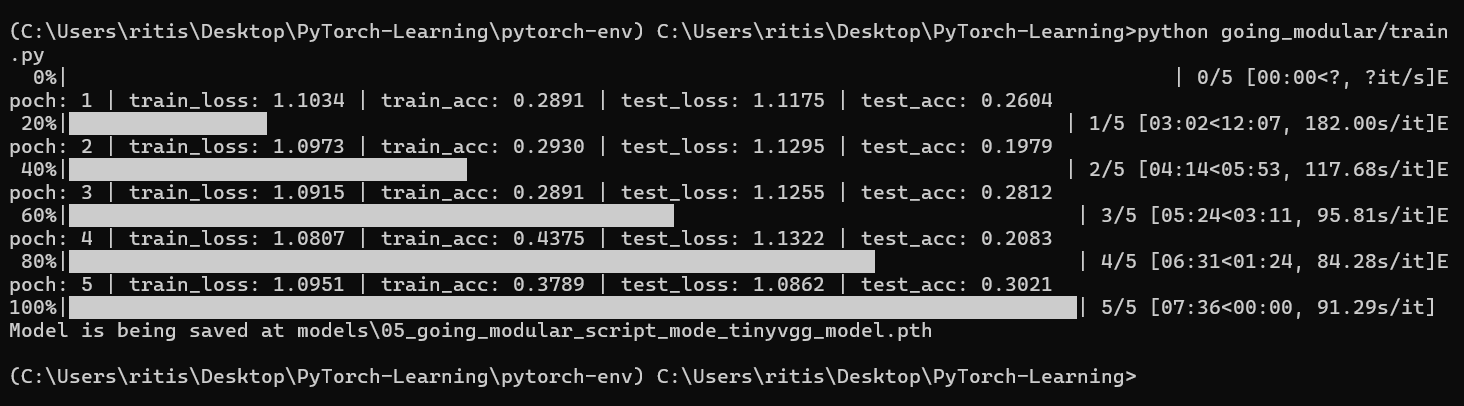

## Exercises

In [12]:
%%writefile going_modular/get_data.py

import os
import requests
import zipfile
from pathlib import Path

def data_access(download_path: Path, download_url: str):
    if download_path.is_dir():
        print(f"Data already exists at {Path(download_path)}, skipping download.")
    else:
        print("Not existing. Creating one.")
        download_path.mkdir(parents = True, exist_ok = True)

    with open(download_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get(download_url)
        print("Downloading...")
        f.write(request.content)

    with zipfile.ZipFile(download_path/"pizza_steak_sushi.zip", "r") as zipf:
        print("Unzipping...")
        zipf.extractall(download_path)

    os.remove(download_path/"pizza_steak_sushi.zip")
    print("Successfully downloaded the data.")

if __name__ == "__main__":
    download_path = Path("data/pizza_steak_sushi/")
    download_url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    data_access(download_path=download_path, download_url=download_url)

Writing going_modular/get_data.py


In [13]:
! python going_modular/get_data.py

Data already exists at data\pizza_steak_sushi, skipping download.
Downloading...
Unzipping...
Successfully downloaded the data.


In [14]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code and argument flags enabled.
"""

import os
import torch
import data_setup, model_builder, engine, utils
from torchvision import transforms

# For command line argument flags
import argparse

def main():
    parser = argparse.ArgumentParser(description = "Argument flags enabled")

    parser.add_argument('--train_dir', default = 'data/pizza_steak_sushi/train', type = str)
    parser.add_argument('--test_dir', default = 'data/pizza_steak_sushi/test', type=str)
    parser.add_argument('--learning_rate', default = 0.001, type=float)
    parser.add_argument('--batch_size', default = 32, type=int)
    parser.add_argument('--epochs', default = 5, type = int)
    parser.add_argument('--hidden_units', default = 10, type = int)

    args = parser.parse_args()

    # Setup hyperparameters
    NUM_EPOCHS = args.epochs
    BATCH_SIZE = args.batch_size
    HIDDEN_UNITS = args.hidden_units
    LEARNING_RATE = args.learning_rate
    print(f"[INFO] Training model for {NUM_EPOCHS} with batch size {BATCH_SIZE} using {HIDDEN_UNITS} hidden units and an lr of {LEARNING_RATE}")

    # Setup train and test directories
    train_dir = args.train_dir
    test_dir = args.test_dir
    print(f"[INFO] Train dir is: {train_dir}")
    print(f"[INFO] Test dir is: {test_dir}")

    # Setup device agnostic code
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Create transforms
    data_transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()
    ])
    
    # Create DataLoaders using data_setup.py
    train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir, test_dir, data_transform, BATCH_SIZE)
    
    # Create model using model_builder.py
    model = model_builder.TinyVGG(3, HIDDEN_UNITS, len(class_names)).to(device)
    
    # Setup loss fn and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Start training using engine.py
    engine.train(model, train_dataloader, test_dataloader, loss_fn, optimizer, NUM_EPOCHS, device)
    
    # Save the model using utils.py
    utils.save_model(model, "models", "05_going_modular_script_mode_tinyvgg_model.pth")

# Required on windows to avoid endless running
if __name__ == "__main__":
    main()

Overwriting going_modular/train.py


In [15]:
! python going_modular/train.py --learning_rate 0.003 --batch_size 64 --epochs 20 --hidden_units 128

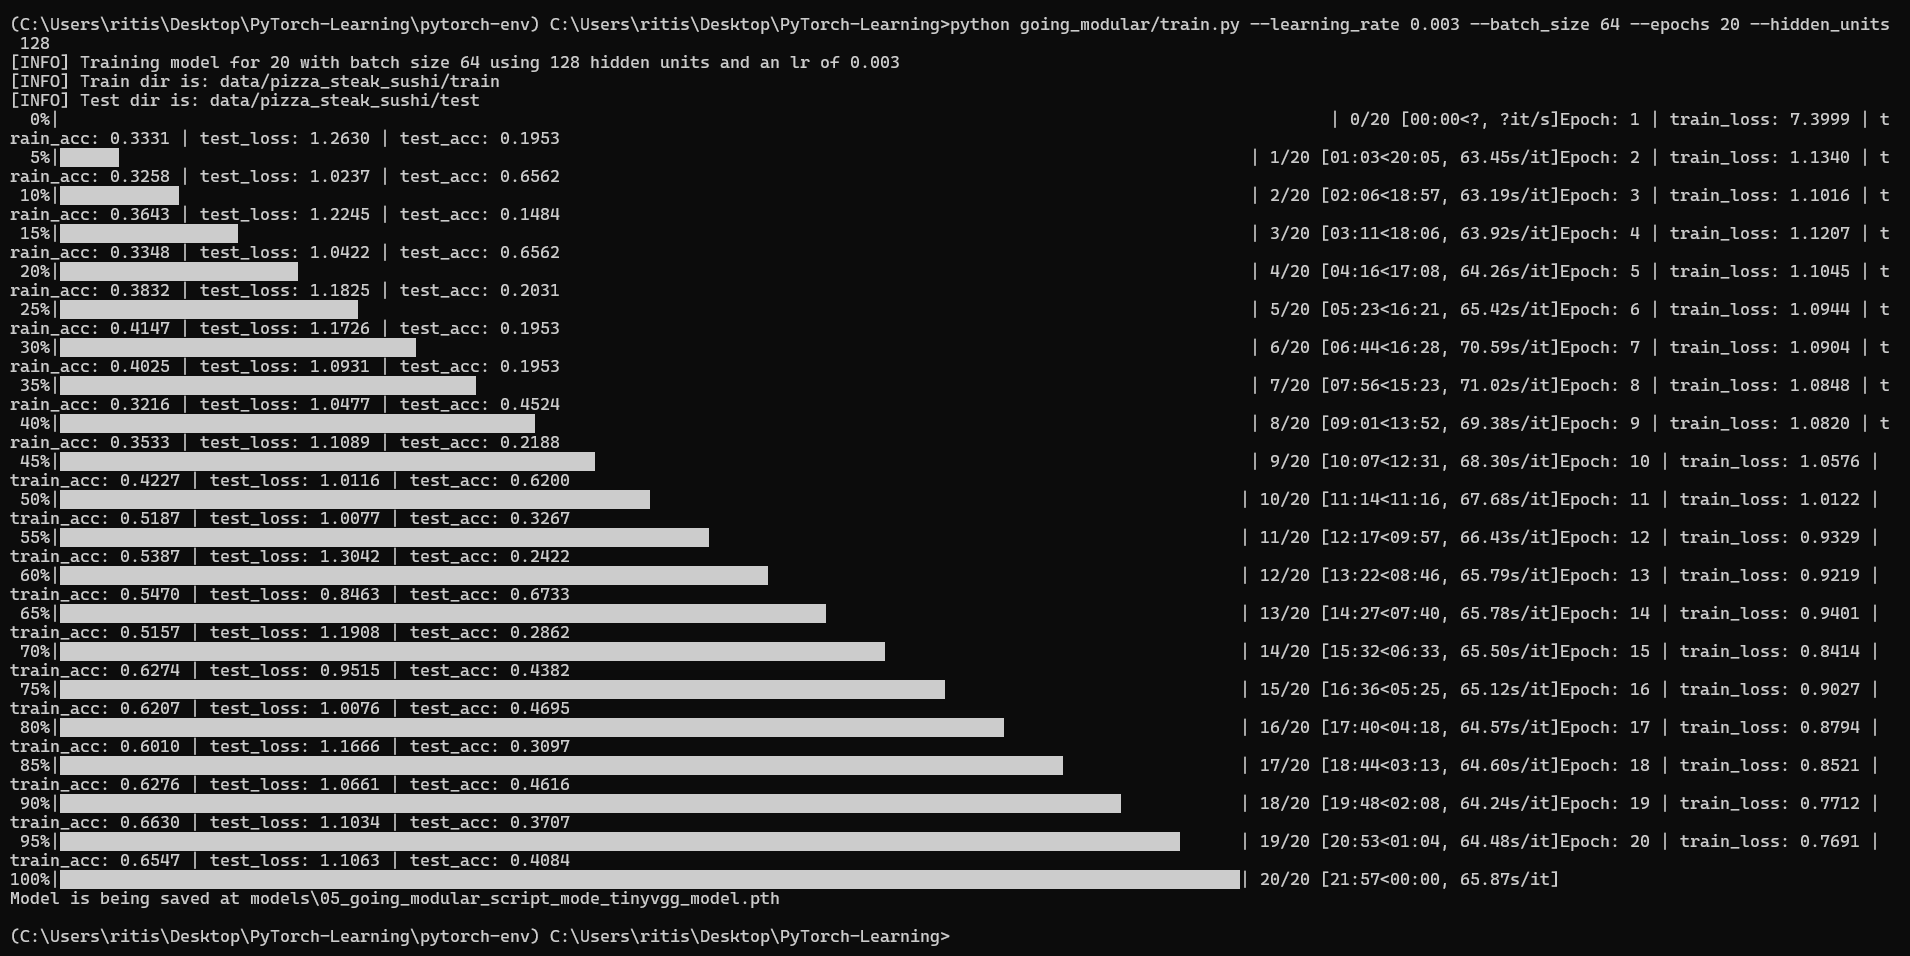

In [15]:
%%writefile going_modular/predict.py

import torch
import torchvision
import os
import argparse
from torchvision import transforms
from typing import Tuple
import model_builder

parser = argparse.ArgumentParser()

parser.add_argument('--model_file_path', default = 'models/05_going_modular_script_mode_tinyvgg_model.pth', type = str)
parser.add_argument('--image', type = str)

args = parser.parse_args()

device = "cuda" if torch.cuda.is_available() else "cpu"

def prediction(model_file_path: str=args.model_file_path, image_path: str=args.image, device: torch.device=device) -> Tuple[str, str]:

    class_names = ['pizza', 'steak', 'sushi']
    
    loaded_model = model_builder.TinyVGG(3, 128, len(class_names)).to(device)
    loaded_model.load_state_dict(torch.load(model_file_path, weights_only = True))
    
    loaded_image = torchvision.io.read_image(str(image_path)).type(torch.float32) / 255.

    transform = transforms.Compose([
        transforms.Resize((64, 64))
    ])

    transformed_image = transform(loaded_image).unsqueeze(dim=0).to(device)

    loaded_model.eval()
    with torch.inference_mode():
        logit = loaded_model(transformed_image)
        prob = torch.softmax(logit, dim = 1)
        pred_label = class_names[torch.argmax(prob, dim = 1).cpu()]
    orig_label = os.path.basename(args.image).split(".")[0]

    return pred_label, orig_label

if __name__ == "__main__":
    pred, og = prediction()
    print(f"Predicted class is: {pred}")
    print(f"Original class is: {og}")

Writing going_modular/predict.py


In [16]:
! python going_modular/predict.py --image data/steak.jpg

Predicted class is: steak
Original class is: steak
